In [4]:
import time

import cvxpy as cp
import gurobipy as gp
import numpy as np
from gurobipy import GRB
from scipy.linalg import qr
# new line added

# a new function
def solve_primal(A, y, U):
    m = U.shape[1]
    p = cp.Variable(m)
    obj = cp.Minimize(cp.norm1(p))
    cons = [np.maximum(0, A @ U) @ p == y]
    prob = cp.Problem(obj, cons)
    p_norm1 = prob.solve()
    return prob, p.value, p_norm1

# 找一个违反约束的u find a violation of the constraints
def get_violation(v, A):
    d = A.shape[1]
    while 1:
        vec = np.random.randn(d)
        vec = vec / np.linalg.norm(vec)
        # print(v.shape, A.shape, vec.shape)
        if v.T @ np.maximum(A @ vec, 0) >= 1 or v.T @ np.maximum(A @ vec, 0) <= -1:
            break
    return vec


# 从A,U计算出定义优化问题所需的A_ub
def get_Aub(A, U):
    AU_T = np.maximum(A @ U, 0).T
    (m, n) = AU_T.shape
    A_ub = np.empty((2 * m, n))
    A_ub[::2] = AU_T
    A_ub[1::2] = -AU_T
    # print(A.shape,U.shape)
    return A_ub


# 初始化模型
def init_Uvmodel(A, y, U, bound, LPwarmstart, seed):
    np.random.seed(seed)

    model = gp.Model()
    model.setParam("OutputFlag", 0)
    model.setParam("Method", 0)  # 原始单纯形法
    model.setParam("LPwarmstart", LPwarmstart)

    m = U.shape[1]
    d = A.shape[1]
    A_ub = get_Aub(A, U)

    lambda_m = model.addMVar(2 * m, name="lambda_m")
    model.setObjective(lambda_m.sum(), sense=GRB.MINIMIZE)
    # print(A_ub.shape,y.shape)
    model.addMConstr(A_ub.T, lambda_m, "=", y)
    model.optimize()
    # while model.Status == GRB.INF_OR_UNBD:
    while model.Status == GRB.INFEASIBLE:  # 当问题不可行时，就往U中添加随机单位向量
        print(model.Status, end=" ")
        vec = get_violation(y, A)
        U = np.hstack((U, vec.reshape(d, -1)))
        Avec = np.maximum(A @ vec, 0)
        add_columns = np.vstack((Avec, -Avec))
        # print(add_columns.shape, len(model.getConstrs()))
        for i in range(2):
            model.addVar(
                obj=1.0,
                column=gp.Column(add_columns[i, :].ravel(), model.getConstrs()),
            )  # 添加变量，及相关的目标函数和约束中的系数
        model.optimize()

    v_np = np.array(model.getAttr(GRB.Attr.Pi, model.getConstrs()))  # 取出初始化后的v
    return model, U, v_np


# 更新基以用于加约束之后的warmstart
def update_Vbasis(model, flag):
    return model.getAttr("Vbasis") + [-1] * 2 * flag


# 更新解以用于加约束之后的warmstart
def update_PDstart(model):
    return model.getAttr(GRB.Attr.X, model.getVars()) + [
        0.0,
        0.0,
        0.0,
        0.0,
    ], model.getAttr(GRB.Attr.Pi, model.getConstrs())


# 更新模型
def update_model(model, u_1, flag_1, u_2, flag_2):
    Au1 = np.maximum(A @ u_1, 0)  # 在子问题2原有model的基础上添加变量，添加约束矩阵的列
    Au2 = np.maximum(A @ u_2, 0)
    add_columns = np.vstack((Au1, -Au1, Au2, -Au2))
    flags = [flag_1, flag_2]
    # print(add_columns.shape, len(model_dual.getConstrs()))
    for i, flag in enumerate(flags):
        if flag:
            for j in range(2):
                model.addVar(
                    obj=1.0,
                    column=gp.Column(
                        add_columns[2 * i + j, :].ravel(), model.getConstrs()
                    ),
                )
    model.update()
    return model


# 随机生成数据用于测试
def random_Ay(n, d, seed):
    np.random.seed(seed)

    Q, _ = qr(np.random.randn(d, d))
    A = Q[:n]
    # A = np.random.randn(n, d)

    y = 2 * (np.random.random(n) - 0.5)

    return A, y

In [ ]:
n = 39
d = 40
bound = 1
tolerance = 1e-6
LPwarmstart = 1
seed = 1
# np.random.seed(seed)
# A = np.array([[-2, 1], [-1, 1], [0, 1], [1, 1], [2, 1]])
# y = np.array([1, -1, 1, 1, -1])
A, y = random_Ay(n, d, seed)
# A=np.random.randn(n,d)
np.diag(A @ A.T)

In [9]:
U = get_violation(y, A).reshape(d, -1)

v = y

# 子问题2 初始化
model_dual, U, v = init_Uvmodel(A, y, U, bound, LPwarmstart, seed=seed)

print(
    f"shape of data matrix: {A.shape}, shape of label: {y.shape}, shape of initialized U: {U.shape}"
)
print(f"initialized v: {v}")

3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 shape of data matrix: (39, 40), shape of label: (39,), shape of initialized U: (40, 39)
initialized v: [ 2.70322240e+02  3.18495930e+01  5.49215956e+00  2.46735973e+01
  1.10218900e+02  5.72745966e-01  3.34050928e+01 -1.08699222e+02
 -6.90507961e+01 -6.15968173e+01 -1.81204087e+00  1.89016510e+01
 -4.07833062e+01  8.80750034e+00 -2.74919942e+01  1.66792787e+01
  3.44936479e+01 -4.44862767e+01 -6.32087001e+00 -5.67642646e+01
 -1.11866711e+01  1.11494537e+02 -8.15437943e+01 -2.38289610e+00
  5.94268247e+00  1.01013781e+02  2.08775037e+01  5.38314852e+01
  3.81083447e+00 -4.61705356e+00 -2.13271349e+01 -2.25341934e+01
 -7.73862418e+01  1.54154173e+01  3.38396449e+00  5.69035129e+01
 -1.21237718e+01  1.01575056e+02 -2.15739999e-02]


In [ ]:
Lambda = cp.Variable(n)
Av_parameter = cp.Parameter(d)
obj_1 = cp.Minimize(cp.sum_squares(A.T @ Lambda - Av_parameter))
cons_1 = [Lambda >= 0]
prob_1 = cp.Problem(obj_1, cons_1)

v = y

Av = A.T @ v
Av_parameter.value = Av  # 解子问题1
prob_1.solve(warm_start=True)
u_1 = (A.T @ Lambda.value - Av) / np.linalg.norm(A.T @ Lambda.value - Av)
f_min = v @ A @ u_1
bool_min = f_min >= -bound - tolerance

Av_parameter.value = -Av  # 解子问题1
prob_1.solve(warm_start=True)
u_2 = (A.T @ Lambda.value + Av) / np.linalg.norm(A.T @ Lambda.value + Av)
f_max = v @ A @ u_2
bool_max = f_max <= bound + tolerance

print(u_1, u_2)

In [10]:
# model_dual.setParam("OutputFlag", 1)

# 设定算法参数，记录迭代信息
max_iteration = 1500
iteration = np.zeros(max_iteration, int)
pd_value = np.zeros(max_iteration)
T = np.zeros(2)
# primal_f = []

# 子问题1 初始化
# w = cp.Variable(n)
# v_parameter = cp.Parameter(n)
# obj_1 = cp.Minimize(cp.quad_form(w, A @ A.T))
# cons_1 = [w >= -v_parameter]
# prob_1 = cp.Problem(obj_1, cons_1)
Lambda = cp.Variable(n)
Av_parameter = cp.Parameter(d)
obj_1 = cp.Minimize(cp.sum_squares(A.T @ Lambda - Av_parameter))
cons_1 = [Lambda >= 0]
prob_1 = cp.Problem(obj_1, cons_1)

for ii in range(max_iteration):
    t0 = time.time()

    Av = A.T @ v
    Av_parameter.value = Av  # 解子问题1
    prob_1.solve(warm_start=True)
    u_1 = (A.T @ Lambda.value - Av) / np.linalg.norm(A.T @ Lambda.value - Av)
    f_min = v @ A @ u_1
    bool_min = f_min >= -bound - tolerance

    Av_parameter.value = -Av  # 解子问题1
    prob_1.solve(warm_start=True)
    u_2 = (A.T @ Lambda.value + Av) / np.linalg.norm(A.T @ Lambda.value + Av)
    f_max = v @ A @ u_2
    bool_max = f_max <= bound + tolerance

    t1 = time.time()
    T[0] += t1 - t0

    if bool_max and bool_min:  # 当满足容忍度要求时退出循环
        print(f"tolerance {tolerance} satisfied")
        print(f"total iterations: {ii}, total time cost: {T.sum()}")
        print(f"min_vAu={f_min}, max_vAu={f_max}")
        # print(u_1,u_2,v)
        break

    if not bool_min:
        U = np.hstack((U, u_1.reshape(d, -1)))  # 更新U
    if not bool_max:
        U = np.hstack((U, u_2.reshape(d, -1)))

    # _, p, _ = solve_primal(A, y, U)
    # pd_value[0, ii] = np.linalg.norm(p, 1)

    Vbasis = update_Vbasis(model_dual, 2 - bool_max - bool_min)  # 更新基
    # Pstart, Dstart = update_PDstart(model_dual)  # 更新解
    model_dual = update_model(model_dual, u_1, 1 - bool_min, u_2, 1 - bool_max)

    # print(len(model_dual.getVars()),len(Vbasis))
    model_dual.setAttr("VBasis", model_dual.getVars(), Vbasis)  # 指定基warmstart
    model_dual.setAttr("CBasis", model_dual.getConstrs(), [-1] * n)

    # model_dual.setAttr("PStart", model_dual.getVars(), Pstart)  # 指定解warmstart
    # model_dual.setAttr("Dstart", model_dual.getConstrs(), Dstart)

    model_dual.optimize()
    if model_dual.Status != GRB.OPTIMAL:
        print("not optimal!")
        break

    iteration[ii] = int(model_dual.getAttr("IterCount"))  # 记录迭代次数
    if not ii % 10:
        print(iteration[ii], end=" ")
    if not ii % 100:
        print(f_min, f_max)
    v = np.array(model_dual.getAttr(GRB.Attr.Pi, model_dual.getConstrs()))  # 取出v

    pd_value[ii] = v @ y

    t2 = time.time()
    T[1] += t2 - t1

    if ii == max_iteration - 1:
        print("max iteration!")
        print(f"min_vAu={f_min}, max_vAu={f_max}")
v

20 -204.7950613695331 360.163420114452
21 15 19 17 15 11 14 15 17 16 -1.3048057992280486 1.2523786510682926
9 13 11 10 20 18 14 9 15 12 -1.0645098783287947 1.022617091309487
14 7 29 17 14 11 12 9 26 9 -1.0143642990952264 1.00102623646191
24 24 14 9 28 13 11 11 10 14 -1.0031755513428104 1.0000302160269408
10 7 12 12 15 9 10 7 12 8 -1.0009706920557728 1.0000008814256944
4 10 8 5 4 13 11 11 4 11 -1.0003193951780578 1.0000008814259373
6 5 4 24 4 11 9 8 7 6 -1.0000872852146099 1.0000008814260095
5 4 20 6 8 7 9 6 9 5 -1.0000408818986162 1.0000008814260006
8 7 11 5 11 4 9 5 10 5 -1.0000107991350018 1.0000008814260302
13 12 4 7 7 5 13 17 8 8 -1.0000042847284802 1.0000008814260357
1 5 6 4 4 11 4 4 7 1 -1.0000010983411916 1.0000008814260344
tolerance 1e-06 satisfied
total iterations: 1109, total time cost: 11.563103914260864
min_vAu=-1.0000008718394282, max_vAu=1.0000008814260335


array([ 0.42985917,  0.11655134, -0.18292597, -0.22020316,  0.29608363,
       -0.18457541,  0.04811871,  0.30248742, -0.19094791, -0.22873807,
       -0.32364979, -0.24757716,  0.42691451, -0.27796556, -0.19409957,
       -0.32851407,  0.21386291, -0.18850943, -0.06056342, -0.25364179,
       -0.08659425, -0.05297613, -0.01899209, -0.05436954, -0.27944298,
        0.33105351, -0.25512541, -0.0532152 , -0.16057482, -0.14012639,
        0.20921991,  0.02173932, -0.21778816, -0.02206224, -0.11276328,
        0.24846064, -0.19254333,  0.4189958 ,  0.03214931])

In [11]:
pd_value[1000:1010]

array([4.49151852, 4.49151845, 4.49151841, 4.49151836, 4.49151829,
       4.49151822, 4.49151818, 4.49151816, 4.49151816, 4.49151815])

In [24]:
# model_dual.setParam("OutputFlag", 1)

# 设定算法参数，记录迭代信息
max_iteration = 1500
iteration = np.zeros(max_iteration, int)
pd_value = np.zeros((2, max_iteration))
T = np.zeros(2)
# primal_f = []

# 子问题1 初始化
w = cp.Variable(n)
v_parameter = cp.Parameter(n)
obj_1 = cp.Minimize(cp.quad_form(w, A @ A.T))
cons_1 = [w >= -v_parameter]
prob_1 = cp.Problem(obj_1, cons_1)

for ii in range(max_iteration):
    t0 = time.time()

    v_parameter.value = v  # 解子问题1
    prob_1.solve(warm_start=True)
    u_1 = (A.T @ w.value) / np.linalg.norm(A.T @ w.value)
    f_min = v @ A @ u_1
    bool_min = f_min >= -bound - tolerance

    v_parameter.value = -v  # 解子问题1
    prob_1.solve(warm_start=True)
    u_2 = (A.T @ w.value) / np.linalg.norm(A.T @ w.value)
    f_max = v @ A @ u_2
    bool_max = f_max <= bound + tolerance

    t1 = time.time()
    T[0] += t1 - t0

    if bool_max and bool_min:  # 当满足容忍度要求时退出循环
        print(f"tolerance {tolerance} satisfied")
        print(f"total iterations: {ii}, total time cost: {T.sum()}")
        print(f"min_vAu={f_min}, max_vAu={f_max}")
        # print(u_1,u_2,v)
        break

    if not bool_min:
        U = np.hstack((U, u_1.reshape(d, -1)))  # 更新U
    if not bool_max:
        U = np.hstack((U, u_2.reshape(d, -1)))

    # _, p, _ = solve_primal(A, y, U)
    # pd_value[0, ii] = np.linalg.norm(p, 1)

    Vbasis = update_Vbasis(model_dual, 2 - bool_max - bool_min)  # 更新基
    # Pstart, Dstart = update_PDstart(model_dual)  # 更新解
    model_dual = update_model(model_dual, u_1, 1 - bool_min, u_2, 1 - bool_max)

    # print(len(model_dual.getVars()),len(Vbasis))
    model_dual.setAttr("VBasis", model_dual.getVars(), Vbasis)  # 指定基warmstart
    model_dual.setAttr("CBasis", model_dual.getConstrs(), [-1] * n)

    # model_dual.setAttr("PStart", model_dual.getVars(), Pstart)  # 指定解warmstart
    # model_dual.setAttr("Dstart", model_dual.getConstrs(), Dstart)

    model_dual.optimize()
    if model_dual.Status != GRB.OPTIMAL:
        print("not optimal!")
        break

    iteration[ii] = int(model_dual.getAttr("IterCount"))  # 记录迭代次数
    if not ii % 10:
        print(iteration[ii], end=" ")
    if not ii % 100:
        print(f_min, f_max)
    v = np.array(model_dual.getAttr(GRB.Attr.Pi, model_dual.getConstrs()))  # 取出v

    # pd_value[1, ii] = v @ y

    t2 = time.time()
    T[1] += t2 - t1

    if ii == max_iteration - 1:
        print("max iteration!")
        print(f"min_vAu={f_min}, max_vAu={f_max}")

tolerance 1e-06 satisfied
total iterations: 0, total time cost: 0.010678768157958984
min_vAu=-1.0000000059426026, max_vAu=0.4594391833253787


In [52]:
prob_primal, p, p_norm1 = solve_primal(A, y, U)
prob_primal.status
np.maximum(A @ U, 0) @ p - y, v

(array([ 9.32587341e-15,  1.76830772e-13, -2.65343303e-14,  1.94844141e-13,
         1.34892097e-14, -5.08926234e-13, -2.86853874e-14,  4.88498131e-14,
        -4.64295269e-13,  7.99360578e-14,  3.37063710e-13, -6.55697718e-13,
         8.38218384e-14,  1.31450406e-13,  4.85056439e-13, -1.65312208e-13,
        -1.31006317e-14,  9.39248679e-14, -7.92421684e-14,  7.66053887e-13,
        -1.66838765e-13,  8.32944824e-14, -9.90874049e-15,  1.02667874e-13,
         1.15463195e-14,  2.88657986e-15,  6.43929354e-14,  7.03881398e-14,
        -1.91513472e-13,  1.70752301e-13,  5.94524430e-14, -2.81857870e-14,
        -7.76712028e-13,  1.18709209e-12,  2.42306175e-13,  9.28146449e-14,
        -8.97060204e-14,  2.05169215e-13,  1.38986045e-14]),
 array([ 0.42985266,  0.11604411, -0.1827839 , -0.2206892 ,  0.29557412,
        -0.18469265,  0.04776401,  0.30279642, -0.19114242, -0.22872199,
        -0.32358177, -0.24754164,  0.42692308, -0.2779421 , -0.19435578,
        -0.32833823,  0.21458806, -0

In [57]:
pd_value[900:910]

array([4.4915223 , 4.49152225, 4.49152222, 4.49152217, 4.49152197,
       4.49152179, 4.49152169, 4.49152164, 4.49152152, 4.49152151])

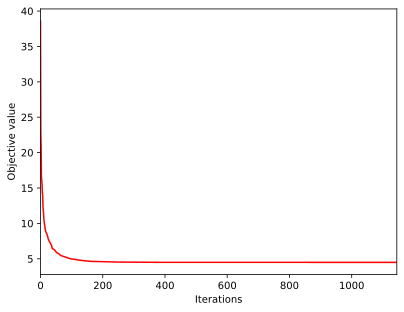

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats("svg")
# color = matplotlib.colormaps.get_cmap('viridis', 4)

plt.semilogy(pd_value[:1145], linewidth=1.5, color="r")
# plt.plot(out1.Lambda_his_norm, linewidth=1.5, color=color(3))

# plt.legend(
#     [

#     ],
#     loc="best",
# )
plt.xlim([0, 1145])
plt.xlabel("Iterations")
plt.ylabel("Objective value")
plt.savefig("Objective_value.png", dpi=500)
plt.show()

In [31]:
indices = np.where(np.abs(p) > 1e-5)[0]
columns = U[:, indices]
p[indices], columns[0, :]

(array([-2.18563912, -5.33699537,  8.21633831, -3.91311897,  0.55901699]),
 array([ 0.99851729,  0.93583067,  0.87349402,  0.4472136 , -0.44721359]))

In [27]:
columns

array([[-0.44626406,  0.04654304,  0.04687946,  0.04706368,  0.04606009],
       [-0.54002754,  0.02999895,  0.031143  ,  0.03054893,  0.03077618],
       [-0.40555125,  0.10756011,  0.10638373,  0.10682993,  0.10672649],
       [-0.18064585, -0.24550809, -0.24608859, -0.24487328, -0.24537437],
       [-0.28419979, -0.61310118, -0.61329864, -0.61349589, -0.61349075],
       [-0.42072725,  0.2835691 ,  0.28300723,  0.28298366,  0.28387772],
       [-0.06200548,  0.25855377,  0.25857194,  0.25863138,  0.25808197],
       [ 0.0241795 , -0.39794583, -0.39888927, -0.39860936, -0.39842973],
       [ 0.06422348,  0.48070956,  0.4798276 ,  0.48039384,  0.48006172],
       [ 0.21396023, -0.11177343, -0.11189459, -0.11163068, -0.11208441]])

In [34]:
def one_test(random_seed):
    n = 39
    d = 40
    bound = 1
    LPwarmstart = 1

    A, y, U = random_AyU(n, d, random_seed)
    #
    model_dual, U, v = init_Uvmodel(A, y, U, bound, LPwarmstart, random_seed)

    # 设定算法参数，记录迭代信息
    max_iteration = 1000
    tolerance = 1e-6
    iteration = np.zeros(max_iteration, int)
    T = np.zeros(2)
    # primal_f = []

    # 子问题1 初始化
    w = cp.Variable(n)
    v_parameter = cp.Parameter(n)
    obj_1 = cp.Minimize(cp.quad_form(w, A @ A.T))
    cons_1 = [w >= -v_parameter]
    prob_1 = cp.Problem(obj_1, cons_1)

    for ii in range(max_iteration):
        t0 = time.time()

        v_parameter.value = v  # 解子问题1
        prob_1.solve(warm_start=True)
        u_1 = (A.T @ (w.value + v) - A.T @ v) / np.linalg.norm(
            A.T @ (w.value + v) - A.T @ v
        )
        f_min = v @ A @ u_1

        v_parameter.value = -v  # 解子问题1
        prob_1.solve(warm_start=True)
        u_2 = (A.T @ (w.value + v) - A.T @ v) / np.linalg.norm(
            A.T @ (w.value + v) - A.T @ v
        )
        f_max = v @ A @ u_2

        t1 = time.time()
        T[0] += t1 - t0

        if f_max <= bound + tolerance and f_min >= -bound - tolerance:  # 当满足容忍度要求时退出循环
            print(f"tolerance {tolerance} satisfied")
            print(f"total iterations: {ii}, total time cost: {T.sum()}")
            print(f"min_vAu={f_min}, max_vAu={f_max}")
            break

        U = np.hstack((U, u_1.reshape(d, -1), u_2.reshape(d, -1)))  # 更新U

        Vbasis = update_Vbasis(model_dual)  # 更新基

        Au1 = np.maximum(A @ u_1, 0)  # 在子问题2原有model的基础上添加变量，添加约束矩阵的列
        Au2 = np.maximum(A @ u_2, 0)
        add_columns = np.vstack((Au1, -Au1, Au2, -Au2))
        # print(len(add_columns[0,:]),len(model_dual.getConstrs()))
        for i in range(4):
            model_dual.addVar(
                obj=1.0,
                column=gp.Column(add_columns[i, :].ravel(), model_dual.getConstrs()),
            )
        model_dual.update()

        # print(len(model_dual.getVars()),len(Vbasis))
        model_dual.setAttr("VBasis", model_dual.getVars(), Vbasis)  # 指定warmstart选项
        model_dual.setAttr("CBasis", model_dual.getConstrs(), [-1] * n)
        model_dual.optimize()
        if model_dual.Status != GRB.OPTIMAL:
            print("not optimal!")
            break

        iteration[ii] = int(model_dual.getAttr("IterCount"))  # 记录迭代次数
        # print(iteration[ii],end=' ')
        v = np.array(model_dual.getAttr(GRB.Attr.Pi, model_dual.getConstrs()))  # 取出v

        t2 = time.time()
        T[1] += t2 - t1

        if ii == max_iteration - 1:
            print("max iteration!")
            print(f"min_vAu={f_min}, max_vAu={f_max}")
    return iteration, T.sum()

In [4]:
epoch = 3

iteration = np.zeros((epoch, 1000))
Time = np.zeros(epoch)

for k in range(epoch):
    iteration[k, :], Time[k] = one_test(k)

tolerance 1e-06 satisfied
total iterations: 857, total time cost: 4.9777162075042725
min_vAu=-1.0000004783794834, max_vAu=1.0000008597572192
tolerance 1e-06 satisfied
total iterations: 852, total time cost: 4.778313159942627
min_vAu=-1.000000870978799, max_vAu=1.000000815828095
tolerance 1e-06 satisfied
total iterations: 903, total time cost: 5.395769357681274
min_vAu=-1.0000008833974041, max_vAu=1.0000009341669773


In [ ]:
np.savez("result_dual_my_warm_start.npz", Time=Time, iteration=iteration)  # 导出测试数据

In [ ]:
# 查看内存使用
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

# Get a sorted list of the objects and their sizes
sorted(
    [
        (x, sys.getsizeof(globals().get(x)))
        for x in dir()
        if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
    ],
    key=lambda x: x[1],
    reverse=True,
)

In [ ]:
print(U.shape)
print(v, np.sum(v))